#### Batches

In [2]:
import pandas as pd
import numpy as np

probabilities = np.loadtxt("probabilities.txt", dtype=float, delimiter=" ")


original_array = probabilities.reshape(145, 145, 2)
batch_dimensions = (47, 47, 2)
top_left_pixel_i, top_left_pixel_j = 0, 0
batches = []
indexes = []


for top_left_pixel_i in range(original_array.shape[0] // (batch_dimensions[0] - 2) + 1):
    for top_left_pixel_j in range(
        original_array.shape[1] // (batch_dimensions[1] - 2) + 1
    ):
        if (
            top_left_pixel_i * (batch_dimensions[0] - 2) + batch_dimensions[0]
            > original_array.shape[0]
        ):
            if (
                top_left_pixel_j * (batch_dimensions[1] - 2) + batch_dimensions[1]
                > original_array.shape[1]
            ):
                batch_start_i = original_array.shape[0] - batch_dimensions[0]
                batch_end_i = original_array.shape[0]
                batch_start_j = original_array.shape[1] - batch_dimensions[1]
                batch_end_j = original_array.shape[1]
            else:
                batch_start_i = original_array.shape[0] - batch_dimensions[0]
                batch_end_i = original_array.shape[0]
                batch_start_j = top_left_pixel_j * (batch_dimensions[1] - 2)
                batch_end_j = (
                    top_left_pixel_j * (batch_dimensions[1] - 2) + batch_dimensions[1]
                )

        elif (
            top_left_pixel_j * (batch_dimensions[1] - 2) + batch_dimensions[1]
            > original_array.shape[1]
        ):
            batch_start_i = top_left_pixel_i * (batch_dimensions[0] - 2)
            batch_end_i = (
                top_left_pixel_i * (batch_dimensions[0] - 2) + batch_dimensions[0]
            )
            batch_start_j = original_array.shape[1] - batch_dimensions[1]
            batch_end_j = original_array.shape[1]
        else:
            batch_start_i = top_left_pixel_i * (batch_dimensions[0] - 2)
            batch_end_i = (
                top_left_pixel_i * (batch_dimensions[0] - 2) + batch_dimensions[0]
            )
            batch_start_j = top_left_pixel_j * (batch_dimensions[1] - 2)
            batch_end_j = (
                top_left_pixel_j * (batch_dimensions[1] - 2) + batch_dimensions[1]
            )

        indexes.append([(batch_start_i, batch_end_i), (batch_start_j, batch_end_j)])
        batches.append(
            original_array[batch_start_i:batch_end_i, batch_start_j:batch_end_j, :]
        )

#### Option 1 : Redo the computation

In [ ]:
import sys
import os
import argparse
import json
import copy
import time
import matplotlib.animation as animation

from construct_ising import *
from embed_my_implementation import *
from embed_piotr_implementation import *

from dwave.samplers import SimulatedAnnealingSampler
from dwave.system import (
    FixedEmbeddingComposite,
    EmbeddingComposite,
    AutoEmbeddingComposite,
    DWaveSampler,
)


import dimod
from dwave.embedding.chimera import find_grid_embedding


"""
Main program
"""

lattice_size = 47  # 47 works
beta = 0.5
list_samplesets = []

for i in range(len(batches)):
    probabilities = batches[i].reshape(-1, 2)

    external_field, neighbors_coupling = hamiltonian(lattice_size, beta, probabilities)

    sampler_param = {
        "beta_range": [],
        "num_reads": 100,
        "num_sweeps": [],
        "num_sweeps_per_beta": [],
        "beta_schedule_type": ["beta_schedule_options"],
        "seed": [],
        "interrupt_function": [],
        "initial_states": [],
        "initial_states_generator": [],
    }

    sampler = EmbeddingComposite(
        DWaveSampler(solver={"topology__type": "pegasus"}, region="eu-central-1")
    )
    sampleset = sampler.sample_ising(
        external_field, neighbors_coupling, num_reads=sampler_param["num_reads"]
    )

    list_samplesets.append(sampleset)

    break

#### Option 2 : Use last exported results

In [4]:
import pickle

with open("list_samplesets_new", "rb") as fp:  # Unpickling
    list_samplesets = pickle.load(fp)

#### Construct final segmentation

In [3]:
result_samples = []
result_energy = []
for sampleset in list_samplesets:
    result_samples.append(np.array(list(sampleset.first.sample.values())))
    result_energy.append(sampleset.first.energy)

In [4]:
final_np_array = np.zeros([original_array.shape[0], original_array.shape[1]])
for i in range(len(result_samples)):
    # 0- Initialisations for current batch
    i_range, j_range = indexes[i]
    batch = result_samples[i].reshape(47, 47)

    # 1- Neutralise unwanted values
    if i_range[0] != 0:
        batch[i_range[0] : i_range[0] + 1, :] = 0
    if i_range[1] != original_array.shape[1]:
        batch[i_range[1] - 1 : i_range[1], :] = 0
    if j_range[0] != 0:
        batch[:, j_range[0] : j_range[0] + 1] = 0
    if j_range[1] != original_array.shape[1]:
        batch[:, j_range[1] - 1 : j_range[1]] = 0

    # 2- Add batch to final np array
    final_np_array[i_range[0] : i_range[1], j_range[0] : j_range[1]] += batch

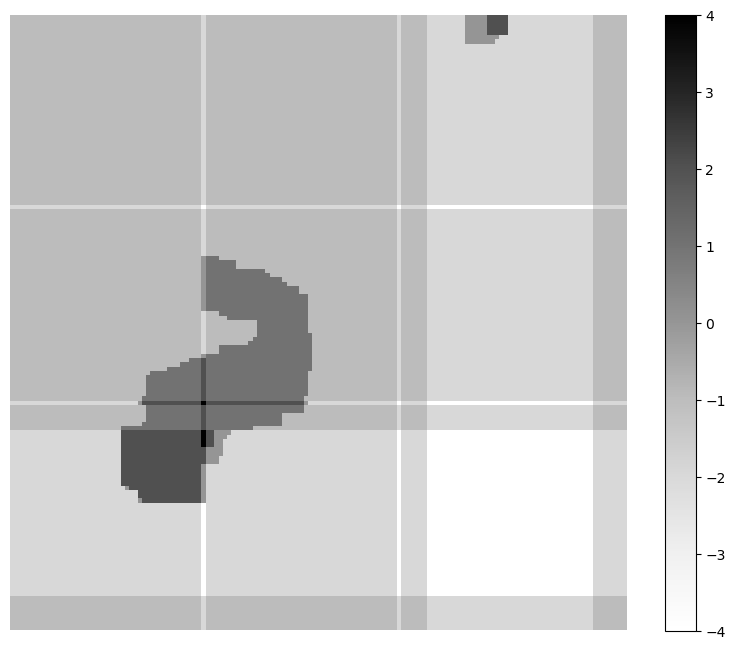

In [6]:
import matplotlib.pyplot as plt


def plot_image(y, fig_name):
    """
    Plot the segmented image
    """

    plt.figure(figsize=(10, 8))
    plt.imshow(y, cmap="Greys")
    plt.colorbar()
    plt.axis("off")
    plt.savefig(fig_name)
    plt.show()


clmap = final_np_array.astype("float")
plot_image(clmap, "dwave_quantum_annealing_segmentation.png")

# print("Energy :{}".format(result_energy))